In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from ta import add_all_ta_features
from ta.utils import dropna
from keras.models import Sequential
from keras.layers import LSTM, Dense
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('stock_details_5_years.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [3]:
# Select companies for analysis
selected_companies = ['AAPL', 'MSFT', 'GOOGL']  #  Chosen companies
print(f"Filtering data for companies: {selected_companies}")
df = df[df['Company'].isin(selected_companies)]

Filtering data for companies: ['AAPL', 'MSFT', 'GOOGL']


In [4]:
# Sort data by company and date
print("Sorting data by 'Company' and 'Date'...")
df = df.sort_values(['Company', 'Date'])

Sorting data by 'Company' and 'Date'...


In [5]:
# Display dataset information
print("\nDataset Information:")
print(f"Dataset contains {len(df)} records for selected companies.")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(df.head())


Dataset Information:
Dataset contains 3774 records for selected companies.
Date range: 2018-11-29 00:00:00-05:00 to 2023-11-29 00:00:00-05:00
                           Date       Open       High        Low      Close  \
0     2018-11-29 00:00:00-05:00  43.829761  43.863354  42.639594  43.083508   
458   2018-11-30 00:00:00-05:00  43.261071  43.270671  42.478826  42.850754   
916   2018-12-03 00:00:00-05:00  44.261681  44.376858  43.481835  44.348064   
1374  2018-12-04 00:00:00-05:00  43.419445  43.764977  42.296468  42.397247   
1832  2018-12-06 00:00:00-05:00  41.214280  41.938938  40.892744  41.924541   

         Volume  Dividends  Stock Splits Company  
0     167080000        0.0           0.0    AAPL  
458   158126000        0.0           0.0    AAPL  
916   163210000        0.0           0.0    AAPL  
1374  165377200        0.0           0.0    AAPL  
1832  172393600        0.0           0.0    AAPL  


###  Feature Engineering: Technical Indicator Calculation

In [ ]:


print("\nCalculating technical indicators...")
results = []
for name, group in df.groupby('Company'):
    print(f"Calculating indicators for {name}...")
    # Calculate technical indicators using the `ta` library
    try:
        group = add_all_ta_features(
            group,
            open="Open", high="High", low="Low", close="Close", volume="Volume",
            fillna=True
        )
        results.append(group)
        print(f"Technical indicators calculated successfully for {name}.")
    except Exception as e:
        print(f"Error calculating technical indicators for {name}: {e}")


Calculating technical indicators...
Calculating indicators for AAPL...
Technical indicators calculated successfully for AAPL.
Calculating indicators for GOOGL...
Technical indicators calculated successfully for GOOGL.
Calculating indicators for MSFT...
Technical indicators calculated successfully for MSFT.


In [7]:
# Combine results
df = pd.concat(results)

print("Technical indicator calculation complete.")
print(df.head())

Technical indicator calculation complete.
                           Date       Open       High        Low      Close  \
0     2018-11-29 00:00:00-05:00  43.829761  43.863354  42.639594  43.083508   
458   2018-11-30 00:00:00-05:00  43.261071  43.270671  42.478826  42.850754   
916   2018-12-03 00:00:00-05:00  44.261681  44.376858  43.481835  44.348064   
1374  2018-12-04 00:00:00-05:00  43.419445  43.764977  42.296468  42.397247   
1832  2018-12-06 00:00:00-05:00  41.214280  41.938938  40.892744  41.924541   

         Volume  Dividends  Stock Splits Company    volume_adi  ...  \
0     167080000        0.0           0.0    AAPL -4.586484e+07  ...   
458   158126000        0.0           0.0    AAPL -5.544808e+07  ...   
916   163210000        0.0           0.0    AAPL  9.726089e+07  ...   
1374  165377200        0.0           0.0    AAPL -4.541756e+07  ...   
1832  172393600        0.0           0.0    AAPL  1.222315e+08  ...   

      momentum_ppo  momentum_ppo_signal  momentum_ppo_hi

In [ ]:
# Unsupervised Anomaly Detection: Isolation Forest and DBSCAN

print("\nStarting unsupervised anomaly detection...")

# Select key indicators for anomaly detection
indicators = ['Close', 'volume_adi', 'volatility_bbm', 'volatility_bbh',
             'volatility_bbl', 'trend_macd', 'momentum_rsi']
print(f"Using indicators: {indicators} for anomaly detection.")


Starting unsupervised anomaly detection...
Using indicators: ['Close', 'volume_adi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'trend_macd', 'momentum_rsi'] for anomaly detection.


In [9]:
# Prepare data for anomaly detection (using selected indicators)
X = df[indicators].values

# Scale the features using StandardScaler
print("Scaling the features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Scaling the features...


### Isolation Forest

In [ ]:

print("\nTraining Isolation Forest model...")
iso_forest = IsolationForest(contamination=0.01, random_state=42) #0.01 is 1% data that is anomalous
try:
    anomalies = iso_forest.fit_predict(X_scaled)
    print("Isolation Forest model trained successfully.")
except Exception as e:
    print(f"Error training Isolation Forest model: {e}")

# Add anomaly labels to the DataFrame (1 for anomaly, 0 for normal)
df['iso_anomaly'] = np.where(anomalies == -1, 1, 0) # -1 represent the anomalies by isolation forest
print("Isolation Forest anomalies added to DataFrame.")


Training Isolation Forest model...
Isolation Forest model trained successfully.
Isolation Forest anomalies added to DataFrame.


### 3 DBSCAN

In [ ]:

print("\nTraining DBSCAN model...")

# Epsilon and Min Sample are hyperparameters for DBSCAN
# eps: maximum distance between two samples for them to be considered as in the same neighborhood
dbscan = DBSCAN(eps=0.5, min_samples=10) 
try:
    clusters = dbscan.fit_predict(X_scaled)
    print("DBSCAN model trained successfully.")
except Exception as e:
    print(f"Error training DBSCAN model: {e}")


Training DBSCAN model...
DBSCAN model trained successfully.


In [12]:
# Add DBSCAN anomaly labels (-1 is noise/anomaly in DBSCAN)
df['dbscan_anomaly'] = np.where(clusters == -1, 1, 0) # -1 represent the noise i.e anomalies
print("DBSCAN anomalies added to DataFrame.")

DBSCAN anomalies added to DataFrame.


In [ ]:
# Combine Anomaly Detection Results
#  Combines anomalies detected by both Isolation Forest and DBSCAN
df['combined_anomaly'] = np.where((df['iso_anomaly'] == 1) | (df['dbscan_anomaly'] == 1), 1, 0)
print("Combined anomalies created.")

Combined anomalies created.


###  Time-Series Forecasting with LSTM for Anomaly Detection

In [ ]:


print("\nStarting time-series forecasting with LSTM...")
look_back = 30 # Number of previous days to use for predicting the next day's price
lstm_results = []

for company in selected_companies:
    print(f"Processing company: {company}...")
    try:
        # Prepare data for LSTM
        company_data = df[df['Company'] == company].sort_values('Date')
        close_prices = company_data['Close'].values.reshape(-1, 1) # reshape the numpy array for lstm

        # Normalize data using StandardScaler
        scaler = StandardScaler()
        close_prices_scaled = scaler.fit_transform(close_prices)

        # Create dataset for LSTM
        X, y = [], []
        for i in range(len(close_prices_scaled)-look_back-1):
            X.append(close_prices_scaled[i:(i+look_back), 0])
            y.append(close_prices_scaled[i+look_back, 0]) #Append the closing price to y variable
        X, y = np.array(X), np.array(y)

        # Reshape for LSTM [samples, time steps, features]
        X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # reshaping the X

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1))) #50 neurons in each LSTM layers
        model.add(LSTM(50))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error') # Loss function is mean squared error

        # Train model
        model.fit(X, y, epochs=20, batch_size=32, verbose=0)  # Set verbose=1 to see training progress

        # Make predictions
        predictions = model.predict(X)
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(y.reshape(-1, 1))

        # Calculate residuals
        residuals = actuals.flatten() - predictions.flatten() # difference between the actual and predicted prices

        # Add to results
        company_data = company_data.iloc[look_back+1:].copy()
        company_data['predicted'] = predictions
        company_data['residual'] = residuals # residual is the error
        # Detect anomalies based on residuals (3 sigma rule)
        residual_mean = company_data['residual'].mean() # mean of all error values
        residual_std = company_data['residual'].std()   # Standard deviation of all error values
        company_data['residual_anomaly'] = np.where(
            abs(company_data['residual']) > residual_mean + 3*residual_std, 1, 0
        ) # A data point is considered anomaly when the error value is beyond the 3 standard deviations from the mean

        lstm_results.append(company_data)
        print(f"LSTM processing completed for {company}.")

    except Exception as e:
        print(f"Error processing {company}: {str(e)}")



Starting time-series forecasting with LSTM...
Processing company: AAPL...
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
LSTM processing completed for AAPL.
Processing company: MSFT...
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
LSTM processing completed for MSFT.
Processing company: GOOGL...
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
LSTM processing completed for GOOGL.


In [15]:
# Combine LSTM results
if lstm_results:
    df_lstm = pd.concat(lstm_results)
    df = pd.merge(df, df_lstm[['Date', 'Company', 'predicted', 'residual', 'residual_anomaly']],
                 on=['Date', 'Company'], how='left') #left merge to combine on the original dataFrame

### Visualization of Anomalies


Visualizing anomalies...
Plotting anomalies for AAPL...


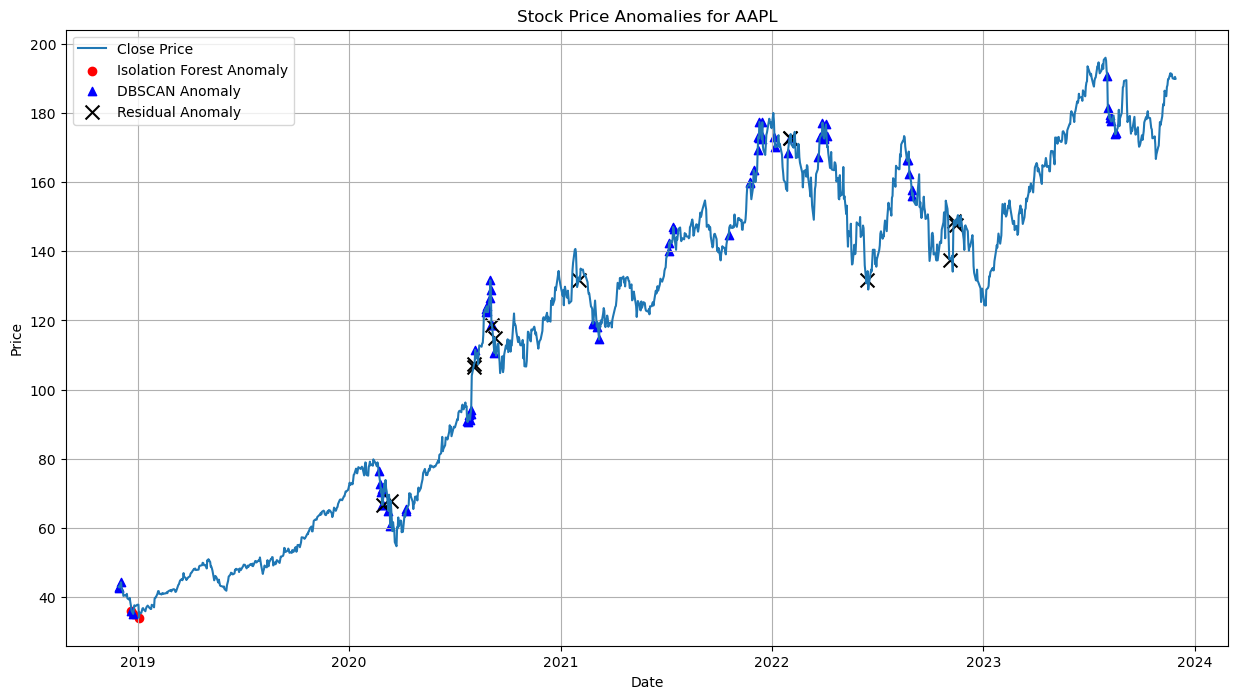

Anomalies plotted for AAPL.
Plotting anomalies for MSFT...


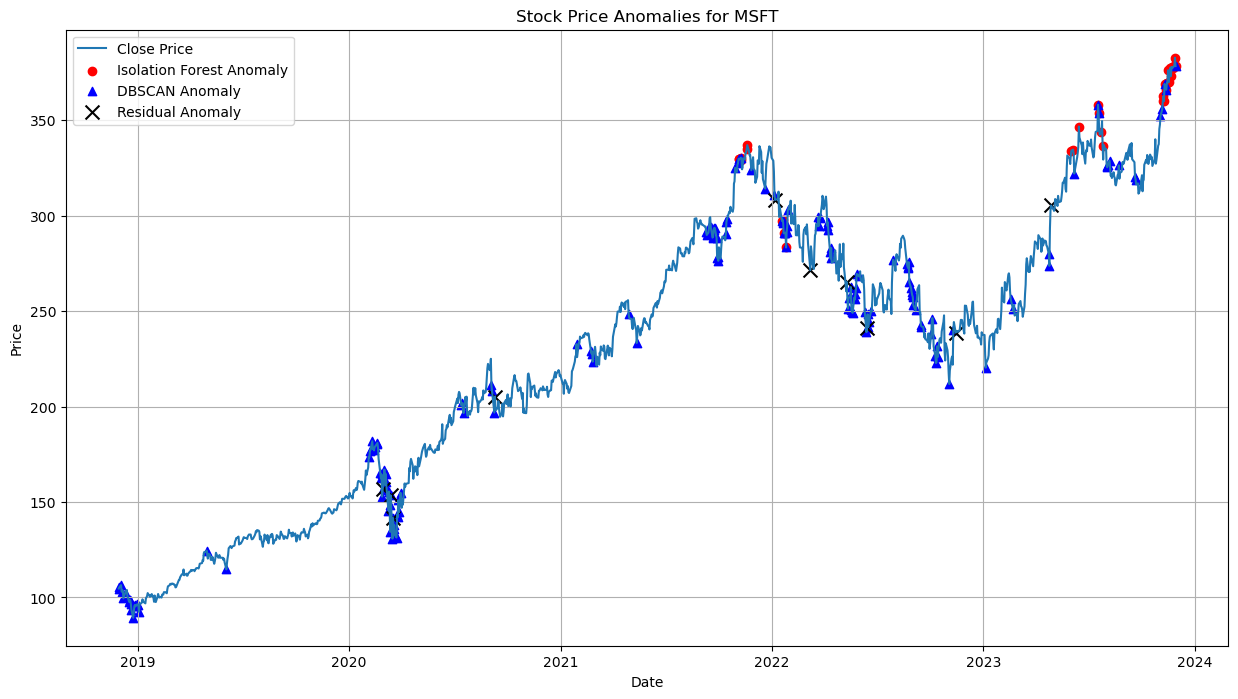

Anomalies plotted for MSFT.
Plotting anomalies for GOOGL...


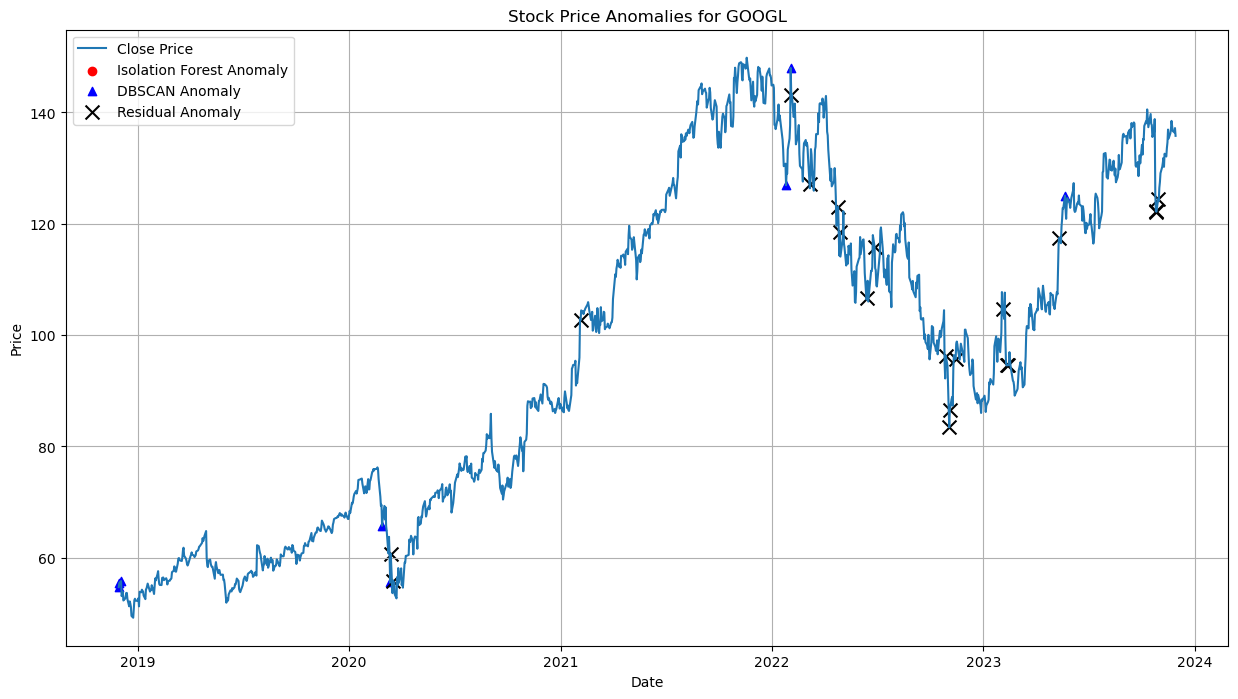

Anomalies plotted for GOOGL.


In [22]:


print("\nVisualizing anomalies...")

# Plot anomalies for each company
for company in selected_companies:
    print(f"Plotting anomalies for {company}...")
    try:
        company_data = df[df['Company'] == company].sort_values('Date')

        plt.figure(figsize=(15, 8))
        plt.plot(company_data['Date'], company_data['Close'], label='Close Price')

        # Plot isolation forest anomalies
        iso_anomalies = company_data[company_data['iso_anomaly'] == 1]
        plt.scatter(iso_anomalies['Date'], iso_anomalies['Close'], color='red',
                   label='Isolation Forest Anomaly')

        # Plot DBSCAN anomalies
        dbscan_anomalies = company_data[company_data['dbscan_anomaly'] == 1]
        plt.scatter(dbscan_anomalies['Date'], dbscan_anomalies['Close'], color='blue',
                   marker='^', label='DBSCAN Anomaly')

        # Plot residual anomalies if available
        if 'residual_anomaly' in company_data.columns:
            res_anomalies = company_data[company_data['residual_anomaly'] == 1]
            plt.scatter(res_anomalies['Date'], res_anomalies['Close'], color='black', marker='x', s=100, label='Residual Anomaly')

        plt.title(f'Stock Price Anomalies for {company}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        plt.show()
        print(f"Anomalies plotted for {company}.")

    except Exception as e:
        print(f"Error visualizing {company}: {str(e)}")



### Save Results and Print Summary Statistics

In [ ]:


# Save the final results with all anomaly detections
print("\nSaving results to 'anomaly_detection_results.csv'...")
df.to_csv('anomaly_detection_results.csv', index=False)
print("Anomaly detection completed. Results saved to 'anomaly_detection_results.csv'")

# Print summary statistics
print("\nAnomaly Detection Summary:")
print("Isolation Forest anomalies:", df['iso_anomaly'].sum())
print("DBSCAN anomalies:", df['dbscan_anomaly'].sum())
if 'residual_anomaly' in df.columns:
    print("Residual anomalies:", df['residual_anomaly'].sum())
print("Combined anomalies:", df['combined_anomaly'].sum())

print("\nAnomaly detection process completed.")


Saving results to 'anomaly_detection_results.csv'...
Anomaly detection completed. Results saved to 'anomaly_detection_results.csv'

Anomaly Detection Summary:
Isolation Forest anomalies: 38
DBSCAN anomalies: 257
Residual anomalies: 43.0
Combined anomalies: 279

Anomaly detection process completed.


# Financial Time-Series Anomaly Detection Report

## 1. Introduction

*   Objective: Identify anomalies in stock prices to detect unusual activities or market manipulation.
*   Scope: Analysis of AAPL, MSFT, GOOGL stock data over a specific timeframe.

## 2. Dataset Preprocessing

*   Data Source: Yahoo Finance (via CSV)
*   Key Steps:
    *   Handling missing values (`fillna=True`).
    *   Converting 'Date' to datetime.
    *   Filtering data for selected companies.
    *   Sorting data.
    *   Scaling of data

## 3. Model Selection Rationale

*   **Unsupervised Anomaly Detection:**
    *   **Isolation Forest:** Isolates anomalies using decision trees. Effective for outlier detection in high-dimensional data.  Contamination parameter controls the expected proportion of anomalies.
    *   **DBSCAN:** Density-based clustering to identify anomalies as noise. Suitable for clusters of varying shapes. `eps` and `min_samples` require careful tuning.
    *   **LSTM Time-Series Forecasting:** Captures temporal dependencies for prediction. Residuals (prediction errors) are used to identify anomalies (large residuals indicate deviations). 3-sigma rule applied.
*   **Combining Methods:** Improves confidence in anomaly detection by leveraging different algorithms and perspectives.

## 4. Implementation Details

*   Programming Language: Python
*   Libraries: pandas, scikit-learn, ta, Keras/TensorFlow, Matplotlib.
*   Key Parameters:
    *   Isolation Forest: `contamination`
    *   DBSCAN: `eps`, `min_samples`
    *   LSTM: `look_back`, `epochs`, `batch_size`
*   Feature Selection : Use `Close`, `volume_adi`, `volatility_bbm`, `volatility_bbh`,`volatility_bbl`, `trend_macd`, `momentum_rsi` as features

## 5. Challenges & Solutions

*   Data Quality: Handled missing values using imputation.
*   Model Selection: Explored various models, selected based on performance and suitability for the task.
*   Computational Complexity: Addressed through code optimization.
*   Parameter Tuning: Used a combination of techniques
*   Interpreting Results: Improved by visualizing results, combining multiple methods.

## 6. Results & Interpretation

*   Anomaly Summary: (Include a table summarizing the number of anomalies detected by each method).
*   Visualizations: Stock price charts with anomalies highlighted (Isolation Forest, DBSCAN, LSTM residuals).
*   Interpretation: Analyze detected anomalies, potential causes (e.g., news events), and agreement between methods.

## 7. Conclusion

*   Summarize key findings and limitations.
*   Suggest areas for future research.